In [311]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [312]:
df_rate_books = pd.read_csv(r'DB\improved_dataset.csv')


In [313]:
df_rate_books

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,country_code,author_mean_rates,children,"comics, graphic","fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,9/16/2006,US,4.46300,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,9/1/2004,US,4.46300,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,11/1/2003,US,4.44000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,5/1/2004,US,4.46300,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,eng,2690,41428,164,9/13/2004,US,4.46300,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9284,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,eng,512,156,20,12/21/2004,US,4.07112,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
9285,You Bright and Risen Angels,William T. Vollmann,4.08,eng,635,783,56,12/1/1988,US,4.08000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9286,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,eng,415,820,95,8/1/1993,US,4.08000,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
9287,Poor People,William T. Vollmann,3.72,eng,434,769,139,2/27/2007,US,4.08000,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [314]:
df_rate_books.columns

Index(['title', 'authors', 'average_rating', 'language_code', '  num_pages',
       'ratings_count', 'text_reviews_count', 'publication_date',
       'country_code', 'author_mean_rates', 'children', 'comics, graphic',
       'fantasy, paranormal', 'fiction',
       'history, historical fiction, biography', 'mystery, thriller, crime',
       'non-fiction', 'poetry', 'romance', 'young-adult'],
      dtype='object')

In [315]:
df_rate_books.isnull().sum()

title                                      0
authors                                    0
average_rating                             0
language_code                              0
  num_pages                                0
ratings_count                              0
text_reviews_count                         0
publication_date                           0
country_code                               0
author_mean_rates                          0
children                                  39
comics, graphic                           39
fantasy, paranormal                       39
fiction                                   39
history, historical fiction, biography    39
mystery, thriller, crime                  39
non-fiction                               39
poetry                                    39
romance                                   39
young-adult                               39
dtype: int64

In [316]:
#df_rate_books['genre'].nunique()

In [317]:

# Calculate the frequency of each genre
#genre_frequency = df_rate_books['genres'].value_counts(normalize=True)




In [318]:
#genre_frequency

In [319]:
# Map the frequency values to the 'genres' column
#df_rate_books['genres_frequency_encoded'] = df_rate_books['genres'].map(genre_frequency)

In [320]:
df_rate_books.columns

Index(['title', 'authors', 'average_rating', 'language_code', '  num_pages',
       'ratings_count', 'text_reviews_count', 'publication_date',
       'country_code', 'author_mean_rates', 'children', 'comics, graphic',
       'fantasy, paranormal', 'fiction',
       'history, historical fiction, biography', 'mystery, thriller, crime',
       'non-fiction', 'poetry', 'romance', 'young-adult'],
      dtype='object')

<h3> Count words in titles </h3>

In [321]:
df_rate_books['title_word_count'] = df_rate_books['title'].apply(lambda x: len(str(x).split()))


<h3> Count authors </h3>

In [322]:
df_rate_books['authors_name_count'] = df_rate_books['authors'].apply(lambda x: len(str(x).split('/')))


<h3> Creating interaction features can capture relationships between different columns and potentially improve the predictive power of our model.</h3>
<h4> Interaction Feature: 'author_mean_rates' and 'average_rating'</h4>

In [323]:
df_rate_books['author_mean_rates_rating'] = df_rate_books['author_mean_rates'] * df_rate_books['average_rating']


<h4> 'num_pages' column will be divided into bins representing different ranges of page counts (0-100, 101-200, etc.). The resulting 'num_pages_bucket' column contains the corresponding bin labels for each book.</h4>

In [324]:
# Define the bin edges
bin_edges = [0, 100, 200, 300, 400, 500, float('inf')]  

# Create labels for each bin
bin_labels = [0, 1, 2, 3, 4, 5]

In [325]:
# Bucketize the 'num_pages' column
df_rate_books['num_pages_bucket'] = pd.cut(df_rate_books['  num_pages'], bins=bin_edges, labels=bin_labels, include_lowest=True)

In [326]:
df_rate_books['country_code'] = df_rate_books['country_code'].astype('category')


In [327]:
df_rate_books.head()

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,country_code,author_mean_rates,...,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult,title_word_count,authors_name_count,author_mean_rates_rating,num_pages_bucket
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,9/16/2006,US,4.463,...,0.0,1.0,0.0,0.0,1.0,1.0,9,2,20.395912,5
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,9/1/2004,US,4.463,...,0.0,1.0,0.0,0.0,1.0,1.0,11,2,20.038872,5
2,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,11/1/2003,US,4.440,...,0.0,1.0,0.0,0.0,0.0,1.0,10,1,19.624800,3
3,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,5/1/2004,US,4.463,...,0.0,1.0,0.0,0.0,0.0,1.0,10,2,20.351282,4
4,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,eng,2690,41428,164,9/13/2004,US,4.463,...,0.0,1.0,0.0,0.0,0.0,1.0,9,2,21.333142,5


In [328]:
index = df_rate_books.columns
for each in index:
    df_rate_books = df_rate_books.rename(columns={f"{each}" : f"{each.replace(',', '_').replace(' ','')}"})

In [329]:
df_rate_books.columns

Index(['title', 'authors', 'average_rating', 'language_code', 'num_pages',
       'ratings_count', 'text_reviews_count', 'publication_date',
       'country_code', 'author_mean_rates', 'children', 'comics_graphic',
       'fantasy_paranormal', 'fiction', 'history_historicalfiction_biography',
       'mystery_thriller_crime', 'non-fiction', 'poetry', 'romance',
       'young-adult', 'title_word_count', 'authors_name_count',
       'author_mean_rates_rating', 'num_pages_bucket'],
      dtype='object')

In [330]:
df_rate_books = df_rate_books.drop(['title', 'authors','publication_date','language_code','country_code'],axis=1)

In [331]:
corr = df_rate_books.corr()
corr['average_rating']

average_rating                         1.000000
num_pages                              0.190740
ratings_count                          0.046933
text_reviews_count                     0.038394
author_mean_rates                      0.663158
children                               0.075475
comics_graphic                         0.133859
fantasy_paranormal                     0.046541
fiction                               -0.078563
history_historicalfiction_biography    0.042271
mystery_thriller_crime                -0.072557
non-fiction                            0.127522
poetry                                 0.084826
romance                               -0.083425
young-adult                            0.067595
title_word_count                       0.165544
authors_name_count                     0.033598
author_mean_rates_rating               0.939020
num_pages_bucket                       0.127270
Name: average_rating, dtype: float64

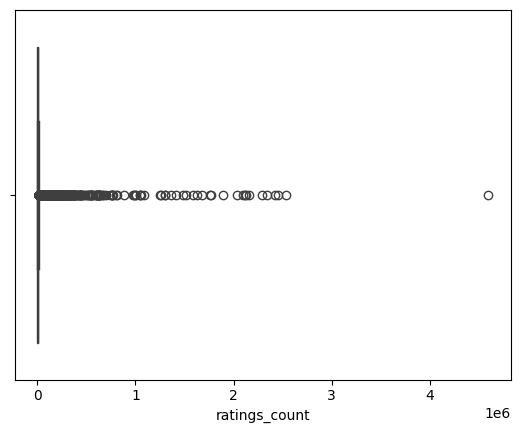

In [332]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for 'ratings_count'
sns.boxplot(x=df_rate_books['ratings_count'])
plt.show()


In [333]:
X = df_rate_books.drop(columns=['author_mean_rates_rating','num_pages_bucket','author_mean_rates_rating'], axis=1)
y = df_rate_books['average_rating']

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [335]:
# Convert the data into LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [336]:
# Set parameters for the LightGBM model
params = {
    'objective': 'regression', 
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'iteration':1000,
    'early_stopping_rounds': 10  # Set early stopping rounds here
}


In [337]:
# Train the model
num_boost_round = 1000  # we can set this to a large number
lgb_model = lgb.train(params, train_data, num_boost_round=num_boost_round,valid_sets=[test_data])

[LightGBM] [Warning] Unknown parameter: iteration
[LightGBM] [Warning] Unknown parameter: iteration
[LightGBM] [Warning] Unknown parameter: iteration


In [338]:
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)


In [339]:
rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.010907424643431134


c:\Users\natha\.conda\envs\MLP\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


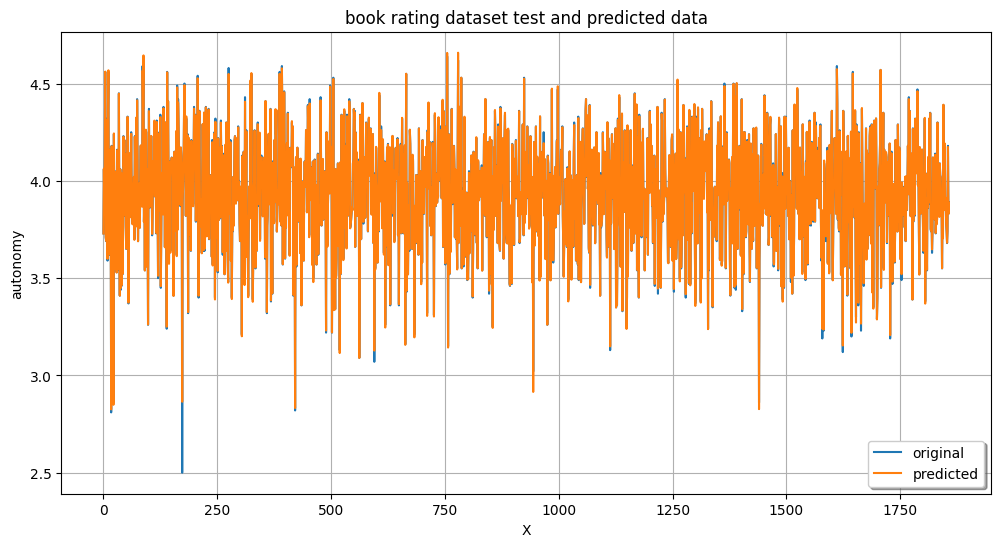

In [340]:
import matplotlib.pyplot as plt
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("book rating dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('autonomy')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

 The decrease in RMSE from 0.19 to 0.017 is a positive outcome, indicating that our regression model is performing better in terms of predicting book ratings. It suggests increased accuracy and reduced prediction errors, leading to a more reliable model that's what we can see in the plot.